In [62]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from data_loader import Dataset

In [63]:
def preprocess(img):
    img = (img / 255.0) * 2 - 1
    return img

def postprocess(img):
    img = (img + 1) / 2 * 255.0
    return img

In [71]:
# Generator
def generator(x, output_channels=4, filters = [64,64,128,256,512,512,512,512], kernel_size = 4, stride = 2):
    with tf.variable_scope('generator'):
        layers = []
        # Encoder:
        x = tf.layers.conv2d(inputs = x,
                             filters = filters[0],
                             kernel_size = 1,
                             strides = 1,
                             padding = 'same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer()) 
        x = tf.layers.batch_normalization(x)
        x =  tf.nn.leaky_relu(x)
        layers.append(x)
        for i in range(1, len(filters)):
            x = tf.layers.conv2d(inputs = x,
                                 filters = filters[i],
                                 kernel_size = kernel_size,
                                 strides = stride,
                                 padding = 'same',
                                 kernel_initializer = tf.contrib.layers.xavier_initializer())  
            x = tf.layers.batch_normalization(x)
            x =  tf.nn.leaky_relu(x)
        # save contracting path layers to be used for skip connections
            layers.append(x)
            
        
        # Decoder:
        for i in reversed(range(len(filters)-1)):
            x = tf.layers.conv2d_transpose(inputs = x,
                                           filters = filters[i],
                                           kernel_size = kernel_size,
                                           strides = stride,
                                           padding = 'same',
                                           kernel_initializer = tf.contrib.layers.xavier_initializer())
            x = tf.layers.batch_normalization(x)
            x =  tf.nn.relu(x)
        # concat the layer from the contracting path with the output of the current layer
        # concat only the channels (axis=3)
            x = tf.concat([layers[i], x], axis=3)
            # layers.append(x)
        x = tf.layers.conv2d(inputs = x,
                             filters = output_channels,
                             kernel_size = 1,
                             strides = 1,
                             padding = 'same',
                             activation = tf.nn.tanh,
                             kernel_initializer = tf.contrib.layers.xavier_initializer())   
        # layers.append(x)
        # return layers
        return x

In [65]:
# Discriminator
def discriminator(x, filters = [64,128,256,512] , kernel_size = 4, stride = 2): # conditional GAN
    """
    filters: Integer, the dimensionality of the output space (i.e. the number of filters in the convolution).
    kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. 
                 Can be a single integer to specify the same value for all spatial dimensions.
    strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. 
             Can be a single integer to specify the same value for all spatial dimensions. 
             Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
    
    filters: a series of 4x4 convolutional layers with stride 2 with the number of channels being doubled after each downsampling.
    All convolution layers are followed by batch normalization, leaky ReLU activation. 
    After the last layer, a convolution is applied to map to a 1 dimensional output, 
        followed by a sigmoid function to return a probability value of the input being real or fake
    """
    
    with tf.variable_scope("discriminator"): 
        # layers = []
        for i in range(len(filters)):
            x = tf.layers.conv2d(inputs = x,
                                 filters = filters[i],
                                 kernel_size = kernel_size,
                                 strides = stride,
                                 padding = 'same',
                                 kernel_initializer = tf.contrib.layers.xavier_initializer())           
            if i != 0: # Do not use batch-norm in the first layer
                x = tf.layers.batch_normalization(x)
            x =  tf.nn.leaky_relu(x)
            # layers.append(x)
        x = tf.contrib.layers.flatten(x)
        logit = tf.layers.dense(inputs = x, units=1, kernel_initializer = tf.contrib.layers.xavier_initializer())
        # layers.append(logit)
        # return layers
        return logit

In [66]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Unnormalized score that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Unnormalized score that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    
    HINT: for the discriminator loss, you'll want to do the averaging separately for
    its two components, and then add them together (instead of averaging once at the very end).
    """
    # TODO: compute D_loss and G_loss
    G_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake), logits=logits_fake)
    G_loss = tf.reduce_mean(G_loss)
    
    D_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits=logits_real)
    D_real_loss = tf.reduce_mean(D_real_loss)
    D_fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits=logits_fake)
    D_fake_loss = tf.reduce_mean(D_fake_loss)
    D_loss = D_real_loss + D_fake_loss
    return D_loss, G_loss

In [67]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate, beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate, beta1)
    return D_solver, G_solver

In [25]:
# CODE DEVELOPMENT FOR PREPORCESSING
from data_loader import Dataset
train = Dataset('/home/shared/chris/Histopathology-Imaging/data/gray_examples/', 
                '/home/shared/chris/Histopathology-Imaging/data/color_examples/', 
               16, 500)
for t, (gray, color) in enumerate(train):
    gray_np = gray
    color_np = color

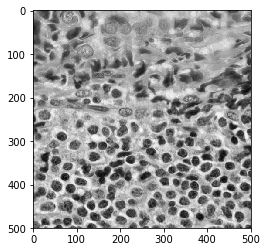

In [46]:
plt.imshow(gray_np[0].astype(np.uint8).reshape((500,500,)), cmap='gray')

In [79]:
# Training-time computation graph
tf.reset_default_graph()

# number of images for each batch
# batch_size = 128
# our noise dimension
# noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 256, 256, 1])
# random noise fed into our generator
# z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(x)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(preprocess(x)) # just testing
    # logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
print(G_vars)

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

[<tf.Variable 'generator/conv2d/kernel:0' shape=(1, 1, 1, 64) dtype=float32_ref>, <tf.Variable 'generator/conv2d/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'generator/batch_normalization/gamma:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'generator/batch_normalization/beta:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'generator/conv2d_1/kernel:0' shape=(4, 4, 64, 64) dtype=float32_ref>, <tf.Variable 'generator/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'generator/batch_normalization_1/gamma:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'generator/batch_normalization_1/beta:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'generator/conv2d_2/kernel:0' shape=(4, 4, 64, 128) dtype=float32_ref>, <tf.Variable 'generator/conv2d_2/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'generator/batch_normalization_2/gamma:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'generator/batch_normalization_2/beta:0' shape=(128,) dtype=float32_ref>, <tf.Variable '

ValueError: No gradients provided for any variable, check your graph for ops that do not support gradients, between variables ["<tf.Variable 'generator/conv2d/kernel:0' shape=(1, 1, 1, 64) dtype=float32_ref>", "<tf.Variable 'generator/conv2d/bias:0' shape=(64,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization/gamma:0' shape=(64,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization/beta:0' shape=(64,) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_1/kernel:0' shape=(4, 4, 64, 64) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_1/gamma:0' shape=(64,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_1/beta:0' shape=(64,) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_2/kernel:0' shape=(4, 4, 64, 128) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_2/bias:0' shape=(128,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_2/gamma:0' shape=(128,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_2/beta:0' shape=(128,) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_3/kernel:0' shape=(4, 4, 128, 256) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_3/bias:0' shape=(256,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_3/gamma:0' shape=(256,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_3/beta:0' shape=(256,) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_4/kernel:0' shape=(4, 4, 256, 512) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_4/bias:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_4/gamma:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_4/beta:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_5/kernel:0' shape=(4, 4, 512, 512) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_5/bias:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_5/gamma:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_5/beta:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_6/kernel:0' shape=(4, 4, 512, 512) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_6/bias:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_6/gamma:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_6/beta:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_7/kernel:0' shape=(4, 4, 512, 512) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_7/bias:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_7/gamma:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_7/beta:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_transpose/kernel:0' shape=(4, 4, 512, 512) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_transpose/bias:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_8/gamma:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_8/beta:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_transpose_1/kernel:0' shape=(4, 4, 512, 1024) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_transpose_1/bias:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_9/gamma:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_9/beta:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_transpose_2/kernel:0' shape=(4, 4, 512, 1024) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_transpose_2/bias:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_10/gamma:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_10/beta:0' shape=(512,) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_transpose_3/kernel:0' shape=(4, 4, 256, 1024) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_transpose_3/bias:0' shape=(256,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_11/gamma:0' shape=(256,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_11/beta:0' shape=(256,) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_transpose_4/kernel:0' shape=(4, 4, 128, 512) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_transpose_4/bias:0' shape=(128,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_12/gamma:0' shape=(128,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_12/beta:0' shape=(128,) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_transpose_5/kernel:0' shape=(4, 4, 64, 256) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_transpose_5/bias:0' shape=(64,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_13/gamma:0' shape=(64,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_13/beta:0' shape=(64,) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_transpose_6/kernel:0' shape=(4, 4, 64, 128) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_transpose_6/bias:0' shape=(64,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_14/gamma:0' shape=(64,) dtype=float32_ref>", "<tf.Variable 'generator/batch_normalization_14/beta:0' shape=(64,) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_8/kernel:0' shape=(1, 1, 128, 4) dtype=float32_ref>", "<tf.Variable 'generator/conv2d_8/bias:0' shape=(4,) dtype=float32_ref>"] and loss Tensor("Mean:0", shape=(), dtype=float32).

In [ ]:
# Training loop
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=1, print_every=1, batch_size=16, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute for the number of iterations we need
    train_data = Dataset('/home/shared/chris/Histopathology-Imaging/data/gray_examples_256/', 
                         '/home/shared/chris/Histopathology-Imaging/data/color_examples_256/', 
                         16, 256, shuffle=False)
    for epoch in range(num_epoch):
        # every show often, show a sample result
        if epoch % show_every == 0:
            samples = sess.run(G_sample)
            plt.imshow(postprocess(samples[0]).astype(np.uint8))
            
        for t, (gray, color) in enumerate(train_data):
            _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: gray})
            _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if epoch % print_every == 0:
            print('Epoch: {}, D: {:.4}, G:{:.4}'.format(epoch,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    plt.imshow(postprocess(samples[0]).astype(np.uint8))

In [18]:
test_function = discriminator
device = '/gpu:0'
tf.reset_default_graph()
B, W, H, C = 16, 256, 256, 5
output_channels = 4
with tf.device(device):
    x = tf.zeros((B, H, W, C))
    layers = test_function(x)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    layers_list = sess.run([layers])
    layers_np_list = layers_list[0]
    for i in range(len(layers_np_list)):
        print(i)
        print(layers_np_list[i].shape)

0
(16, 128, 128, 64)
1
(16, 64, 64, 128)
2
(16, 32, 32, 256)
3
(16, 16, 16, 512)
4
(16, 1)


In [22]:
test_function = generator
device = '/gpu:0'
tf.reset_default_graph()
B, W, H, C = 16, 256, 256, 5
output_channels = 4
with tf.device(device):
    x = tf.zeros((B, H, W, C))
    output = test_function(x)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_np = sess.run(output)
    print(output_np.shape)

(16, 256, 256, 4)


In [60]:
from os import listdir
from shutil import copyfile
def copy_file(org_path_color, org_path_gray, dest_path_color, dest_path_gray, num_files = 100):
    files = [f for f in listdir(org_path_color)]
    for i in range(num_files):
        color_file = files[i]
        gray_file = 'gray_' + color_file
        print('Copying ' + color_file)
        copyfile(org_path_color + color_file, dest_path_color + color_file)
        print('Copying ' + gray_file)
        copyfile(org_path_gray + gray_file, dest_path_gray + gray_file)

In [61]:
copy_file('/home/shared/data/center_4/patches_256/color/', 
          '/home/shared/data/center_4/patches_256/gray/', 
          '/home/shared/chris/Histopathology-Imaging/data/color_examples_256/', 
          '/home/shared/chris/Histopathology-Imaging/data/gray_examples_256/')

Copying 080_4_1006_46464_27136.png
Copying gray_080_4_1006_46464_27136.png
Copying 088_3_3738_70656_29056.png
Copying gray_088_3_3738_70656_29056.png
Copying 090_1_1760_62592_47872.png
Copying gray_090_1_1760_62592_47872.png
Copying 093_1_3994_72064_30080.png
Copying gray_093_1_3994_72064_30080.png
Copying 086_3_3508_62336_48512.png
Copying gray_086_3_3508_62336_48512.png
Copying 097_0_3338_44288_26624.png
Copying gray_097_0_3338_44288_26624.png
Copying 099_0_1317_22144_44544.png
Copying gray_099_0_1317_22144_44544.png
Copying 086_3_4045_64640_49536.png
Copying gray_086_3_4045_64640_49536.png
Copying 095_1_4780_47232_43392.png
Copying gray_095_1_4780_47232_43392.png
Copying 088_3_1213_39168_49024.png
Copying gray_088_3_1213_39168_49024.png
Copying 091_4_929_33280_39424.png
Copying gray_091_4_929_33280_39424.png
Copying 086_3_1964_56448_44160.png
Copying gray_086_3_1964_56448_44160.png
Copying 086_3_1768_55680_53632.png
Copying gray_086_3_1768_55680_53632.png
Copying 080_4_198_37248_529